In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from situation_testing.situation_testing import SituationTesting

# plot params
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [2]:
# working directory
wd = os.path.dirname(os.getcwd())
# relevant folders
data_path = os.path.abspath(os.path.join(wd, 'data')) + '\\'
resu_path = os.path.abspath(os.path.join(wd, 'results')) + '\\'

In [3]:
# load and modify factual data accordingly
org_df = pd.read_csv(data_path + 'LawSchool.csv', sep='|').reset_index(drop=True)
print(org_df.shape)
print(org_df.columns.to_list())
org_df.head(5)

(21790, 7)
['race', 'sex', 'LSAT', 'UGPA', 'ZFYA', 'race_nonwhite', 'race_simpler']


,race,sex,LSAT,UGPA,ZFYA,race_nonwhite,race_simpler
0,White,Female,39.0,3.1,-0.98,White,White
1,White,Female,36.0,3.0,0.09,White,White
2,White,Male,30.0,3.1,-0.35,White,White
3,Hispanic,Male,39.0,2.2,0.58,NonWhite,Latino
4,White,Female,37.0,3.4,-1.26,White,White


In [4]:
# we focus on sex and race_nonwhite
df = org_df[['sex', 'race_nonwhite', 'LSAT', 'UGPA']].copy()
df.rename(columns={'sex': 'Gender', 'race_nonwhite': 'Race'}, inplace=True)
print(df.shape)
print(df.columns.to_list())
df.head(5)

(21790, 4)
['Gender', 'Race', 'LSAT', 'UGPA']


,Gender,Race,LSAT,UGPA
0,Female,White,39.0,3.1
1,Female,White,36.0,3.0
2,Male,White,30.0,3.1
3,Male,NonWhite,39.0,2.2
4,Female,White,37.0,3.4


In [5]:
# Our decision maker:
b1 = 0.6
b2 = 0.4
min_score = round(b1*3.93 + b2*46.1, 2)  # 20.8
max_score = round(b1*4.00 + b2*48.00)    # 22

In [6]:
# add the decision maker
df['Score'] = b1*df['UGPA'] + b2*df['LSAT']
df['Y'] = np.where(df['Score'] >= min_score, 1, 0)
df.head(5)

,Gender,Race,LSAT,UGPA,Score,Y
0,Female,White,39.0,3.1,17.46,0
1,Female,White,36.0,3.0,16.20,0
2,Male,White,30.0,3.1,13.86,0
3,Male,NonWhite,39.0,2.2,16.92,0
4,Female,White,37.0,3.4,16.84,0


### $|\mathbf{A}=1|$: Gender

In [9]:
do = 'Male'
org_cf_df = pd.read_csv(data_path + f'cf_LawSchool_lev3_do{do}.csv', sep='|').reset_index(drop=True)

# added for box-plots
org_cf_df = org_cf_df.rename(columns={'Sex': 'Gender', 'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})

print(org_cf_df.shape)
print(org_cf_df.columns.to_list())
org_cf_df.head(5)

(21790, 8)
['female', 'nonwhite', 'Gender', 'Race', 'resid_LSAT', 'resid_UGPA', 'LSAT', 'UGPA']


,female,nonwhite,Gender,Race,resid_LSAT,resid_UGPA,LSAT,UGPA
0,0,0,Female,White,1.823899,-0.232222,39.609,2.975
1,0,0,Female,White,-1.176101,-0.332222,36.609,2.875
2,0,0,Male,White,-7.784813,-0.107057,30.000,3.100
3,0,1,Male,NonWhite,5.853746,-0.788069,39.000,2.200
4,0,0,Female,White,-0.176101,0.067778,37.609,3.275


In [12]:
# cf_df = org_cf_df[['Sex', 'Race', 'scf_LSAT', 'scf_UGPA']].copy()
# cf_df = cf_df.rename(columns={'Sex': 'Gender', 'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})
cf_df = org_cf_df[['Gender', 'Race', 'LSAT', 'UGPA']].copy()

# add the decision maker
cf_df['Score'] = b1*cf_df['UGPA'] + b2*cf_df['LSAT']
cf_df['Y'] = np.where(cf_df['Score'] >= min_score, 1, 0)
cf_df.head(5)

,Gender,Race,LSAT,UGPA,Score,Y
0,Female,White,39.609,2.975,17.6286,0
1,Female,White,36.609,2.875,16.3686,0
2,Male,White,30.000,3.100,13.8600,0
3,Male,NonWhite,39.000,2.200,16.9200,0
4,Female,White,37.609,3.275,17.0086,0


In [13]:
# store do:=Male results
m_res_df = df[['Gender', 'Race', 'Y']].copy()
m_res_df['cf_Y'] = cf_df[['Y']].copy()
m_res_df.head(5)

,Gender,Race,Y,cf_Y
0,Female,White,0,0
1,Female,White,0,0
2,Male,White,0,0
3,Male,NonWhite,0,0
4,Female,White,0,0


In [51]:
# --- attribute-specific params
feat_trgt = 'Y'
feat_trgt_vals = {'positive': 1, 'negative': 0}
# list of relevant features
feat_rlvt = ['LSAT', 'UGPA']
# protected feature
feat_prot = 'Gender'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': 'Male', 'protected': 'Female'}

# --- st-specific params
# size of neighborhoods
n = 100
# significance level
alpha = 0.05
# tau diviation
tau = 0.0

#### Standard ST (stST)

In [52]:
test_df = df.copy()

st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['Gender'], continuous_atts=['LSAT', 'UGPA'])

m_res_df['stST'] = st.run(target_att=feat_trgt, target_val=feat_trgt_vals,  
                          sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                          k=n, alpha=alpha, tau=tau)

In [53]:
m_res_df[(m_res_df['stST'] > tau)].shape[0]

258

#### Counterfactual Situation Testing (cfST)

In [54]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['LSAT', 'UGPA'])

m_res_df['cfST'] = cf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                             sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                             include_centers=False,
                             k=n, alpha=alpha, tau=tau)

In [55]:
m_res_df[(m_res_df['cfST'] > tau)].shape[0]

296

In [56]:
# get all neighborhoods for ST
stST_knn = st.res_dict_df_neighbors
# get all neighnorhoods for cfST
cfST_knn = cf_st.res_dict_df_neighbors

In [58]:
# complainants in both stST and cfST
set1 = m_res_df[(m_res_df['stST'] > tau) & (m_res_df['cfST'] > tau)].index.to_list()
print(len(set1))

215


In [59]:
# let's look at those c's that appear both in stST and cfST
test_n = 7

test_c = random.sample(set1, test_n)
# test_c = random.sample(set2, test_n)

print(test_c)

var = ['LSAT', 'UGPA']
temp_df_list = []

for c in test_c:

    temp_ctr = org_df.iloc[stST_knn[c]['ctr_idx'], :][var].copy()
    temp_ctr['ID'] = str(c)
    temp_ctr['Type'] = 'ctr'
    temp_df_list.append(temp_ctr)
    del temp_ctr

    temp_tst_st = org_df.iloc[stST_knn[c]['tst_idx'], :][var].copy()
    temp_tst_st['ID'] = str(c)
    temp_tst_st['Type'] = 'tst-st'
    temp_df_list.append(temp_tst_st)
    del temp_tst_st
    
    temp_tst_cf = org_cf_df.iloc[cfST_knn[c]['tst_idx'], :][var].copy()
    temp_tst_cf['ID'] = str(c)
    temp_tst_cf['Type'] = 'tst-cf'
    temp_df_list.append(temp_tst_cf)
    del temp_tst_cf

box_plot_data = pd.concat(temp_df_list)
del temp_df_list

[14822, 1349, 20293, 21272, 13031, 16588, 750]


[Text(0, 0.5, 'LSAT'), Text(0.5, 0, 'Female Complainant ID')]

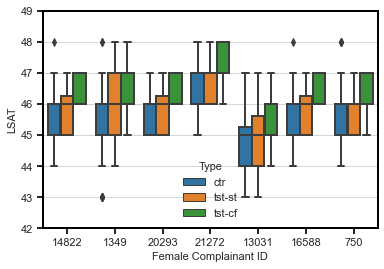

In [68]:
# box_plot_data
plt.ylim(42, 49)
sns.boxplot(x = box_plot_data['ID'],
            y = box_plot_data['LSAT'],
            hue = box_plot_data['Type']).set(ylabel = 'LSAT', xlabel = 'Female Complainant ID')

[Text(0, 0.5, 'UGPA'), Text(0.5, 0, 'Female Complainant ID')]

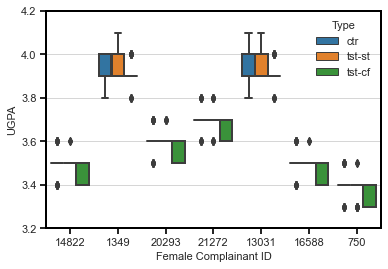

In [69]:
# box_plot_data
plt.ylim(3.2, 4.2)
sns.boxplot(x = box_plot_data['ID'],
            y = box_plot_data['UGPA'],
            hue = box_plot_data['Type']).set(ylabel = 'UGPA', xlabel = 'Female Complainant ID')

### $|\mathbf{A}=1|$: Race

In [72]:
do = 'White'
org_cf_df = pd.read_csv(data_path + '\\' + f'cf_LawSchool_lev3_do{do}.csv', sep='|').reset_index(drop=True)
print(org_cf_df.shape)
print(org_cf_df.columns.to_list())
org_cf_df.head(5)

(21790, 8)
['female', 'nonwhite', 'Sex', 'Race', 'resid_LSAT', 'resid_UGPA', 'scf_LSAT', 'scf_UGPA']


,female,nonwhite,Sex,Race,resid_LSAT,resid_UGPA,scf_LSAT,scf_UGPA
0,1,0,Female,White,1.823899,-0.232222,39.000,3.100
1,1,0,Female,White,-1.176101,-0.332222,36.000,3.000
2,0,0,Male,White,-7.784813,-0.107057,30.000,3.100
3,0,0,Male,NonWhite,5.853746,-0.788069,43.639,2.419
4,1,0,Female,White,-0.176101,0.067778,37.000,3.400


In [73]:
# added for box-plots
org_cf_df = org_cf_df.rename(columns={'Sex': 'Gender', 'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})

cf_df = org_cf_df[['Gender', 'Race', 'LSAT', 'UGPA']].copy()
# cf_df = cf_df.rename(columns={'Sex': 'Gender', 'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})

# add the decision maker
cf_df['Score'] = b1*cf_df['UGPA'] + b2*cf_df['LSAT']
cf_df['Y'] = np.where(cf_df['Score'] >= min_score, 1, 0)
cf_df.head(5)

,Gender,Race,LSAT,UGPA,Score,Y
0,Female,White,39.000,3.100,17.460,0
1,Female,White,36.000,3.000,16.200,0
2,Male,White,30.000,3.100,13.860,0
3,Male,NonWhite,43.639,2.419,18.907,0
4,Female,White,37.000,3.400,16.840,0


In [74]:
# store do:=White results
w_res_df = df[['Gender', 'Race', 'Y']].copy()
w_res_df['cf_Y'] = cf_df[['Y']].copy()
w_res_df.head(5)

,Gender,Race,Y,cf_Y
0,Female,White,0,0
1,Female,White,0,0
2,Male,White,0,0
3,Male,NonWhite,0,0
4,Female,White,0,0


In [88]:
# attribute-specific params
feat_trgt = 'Y'
feat_trgt_vals = {'positive': 1, 'negative': 0}
# list of relevant features
feat_rlvt = ['LSAT', 'UGPA']
# protected feature
feat_prot = 'Race'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': 'White', 'protected': 'NonWhite'}

# st-specific params
# size of neiuborhoods
n = 100
# significance level
alpha = 0.05
# tau diviation
tau = 0.0

#### Standard ST (stST)

In [89]:
test_df = df.copy()

st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])

w_res_df['stST'] = st.run(target_att=feat_trgt, target_val=feat_trgt_vals,  
                          sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                          k=n, alpha=alpha, tau=tau)

In [90]:
w_res_df[(w_res_df['stST'] > tau)].shape[0]

58

#### Counterfactual Situation Testing (cfST)

In [91]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])

w_res_df['cfST'] = cf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                             sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                             include_centers=False,
                             k=n, alpha=alpha, tau=tau)

In [92]:
w_res_df[(w_res_df['cfST'] > tau)].shape[0]

337

In [93]:
# get all neighborhoods for ST
stST_knn = st.res_dict_df_neighbors
# get all neighnorhoods for cfST
cfST_knn = cf_st.res_dict_df_neighbors

In [94]:
# complainants in both stST and cfST
set1 = w_res_df[(w_res_df['stST'] > tau) & (w_res_df['cfST'] > tau)].index.to_list()
print(len(set1))

58


In [95]:
# let's look at those c's that appear both in stST and cfST
test_n = 7

test_c = random.sample(set1, test_n)
# test_c = random.sample(set2, test_n)

print(test_c)

var = ['LSAT', 'UGPA']
temp_df_list = []

for c in test_c:

    temp_ctr = org_df.iloc[stST_knn[c]['ctr_idx'], :][var].copy()
    temp_ctr['ID'] = str(c)
    temp_ctr['Type'] = 'ctr'
    temp_df_list.append(temp_ctr)
    del temp_ctr

    temp_tst_st = org_df.iloc[stST_knn[c]['tst_idx'], :][var].copy()
    temp_tst_st['ID'] = str(c)
    temp_tst_st['Type'] = 'tst-st'
    temp_df_list.append(temp_tst_st)
    del temp_tst_st
    
    temp_tst_cf = org_cf_df.iloc[cfST_knn[c]['tst_idx'], :][var].copy()
    temp_tst_cf['ID'] = str(c)
    temp_tst_cf['Type'] = 'tst-cf'
    temp_df_list.append(temp_tst_cf)
    del temp_tst_cf

box_plot_data = pd.concat(temp_df_list)
del temp_df_list

[12877, 8072, 4281, 10501, 15592, 721, 21558]


[Text(0, 0.5, 'LSAT'), Text(0.5, 0, 'Non-white Complainant ID')]

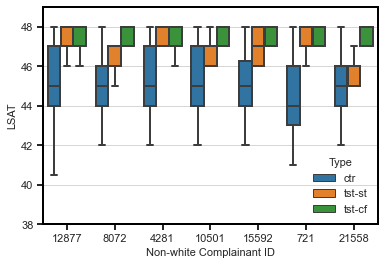

In [103]:
# box_plot_data
plt.ylim(38, 49)
sns.boxplot(x = box_plot_data['ID'],
            y = box_plot_data['LSAT'],
            hue = box_plot_data['Type']).set(ylabel = 'LSAT', xlabel = 'Non-white Complainant ID')

[Text(0, 0.5, 'UGPA'), Text(0.5, 0, 'Non-White Complainant ID')]

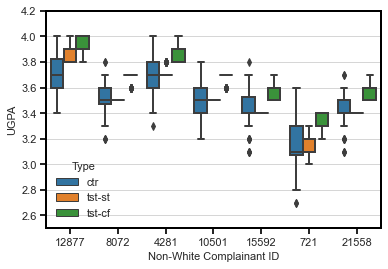

In [100]:
# box_plot_data
plt.ylim(2.5, 4.2)
sns.boxplot(x = box_plot_data['ID'],
            y = box_plot_data['UGPA'],
            hue = box_plot_data['Type']).set(ylabel = 'UGPA', xlabel = 'Non-White Complainant ID')